# Testing machine learning models

## Import libraries

In [1]:
%pip install pyspark

Note: you may need to restart the kernel to use updated packages.


In [2]:
!apt-get install openjdk-11-jdk-headless -qq > /dev/null

The system cannot find the path specified.


In [5]:
import numpy as np
import pandas
import time
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from IPython.core.display import display
from pyspark.sql import SparkSession
from pyspark.sql.types import FloatType
from pyspark.sql import functions as f
from pyspark.sql import Row
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, NaiveBayes, GBTClassifier
# from xgboost.spark import SparkXGBClassifier
from pyspark.ml.evaluation import RegressionEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import MinMaxScaler,StandardScaler
from pyspark.ml.pipeline import PipelineModel

sns.set()

spark = SparkSession.builder.appName('PreprocessingData').config("spark.executor.memory","16g").getOrCreate()
spark

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_7456\1525574797.py:9: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import display


## Read dataset

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
PATH = "/content/drive/MyDrive/dataset/"

In [6]:
dataset = spark.read.csv(PATH+'dataset.csv', header=True, inferSchema=True)
dataset.printSchema()
dataset.show(20,False)
dataset.count()

root
 |-- YEAR: integer (nullable = true)
 |-- QUARTER: integer (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- DAY_OF_MONTH: integer (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- FL_DATE: string (nullable = true)
 |-- OP_UNIQUE_CARRIER: string (nullable = true)
 |-- OP_CARRIER_AIRLINE_ID: integer (nullable = true)
 |-- OP_CARRIER: string (nullable = true)
 |-- TAIL_NUM: string (nullable = true)
 |-- OP_CARRIER_FL_NUM: integer (nullable = true)
 |-- ORIGIN_AIRPORT_ID: integer (nullable = true)
 |-- ORIGIN_AIRPORT_SEQ_ID: integer (nullable = true)
 |-- ORIGIN_CITY_MARKET_ID: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- ORIGIN_CITY_NAME: string (nullable = true)
 |-- ORIGIN_STATE_ABR: string (nullable = true)
 |-- ORIGIN_STATE_FIPS: integer (nullable = true)
 |-- ORIGIN_STATE_NM: string (nullable = true)
 |-- ORIGIN_WAC: integer (nullable = true)
 |-- DEST_AIRPORT_ID: integer (nullable = true)
 |-- DEST_AIRPORT_SEQ_ID: integer (nu

2157737

In [7]:
dataset = dataset.withColumn('DATE', f.split('FL_DATE', ' ')[0]).withColumn('ID', f.concat(f.col('DATE'), f.lit('_'),
                                                                                               f.col('OP_UNIQUE_CARRIER'), f.lit('_'),
                                                                                               f.col('ORIGIN'), f.lit('_'),
                                                                                               f.col('DEST'), f.lit('_'),
                                                                                               f.col('OP_CARRIER_FL_NUM')))
dataset.show(20,False)

+----+-------+-----+------------+-----------+---------------------+-----------------+---------------------+----------+--------+-----------------+-----------------+---------------------+---------------------+------+----------------+----------------+-----------------+---------------+----------+---------------+-------------------+-------------------+----+---------------+--------------+---------------+-------------+--------+------------+--------+---------+-------------+---------+---------------+------------+--------+----------+---------+-------+------------+--------+---------+-------------+---------+---------------+------------+---------+--------+----------------+-------------------+--------+-------+--------+--------------+--------------------+---------+-------------------------+
|YEAR|QUARTER|MONTH|DAY_OF_MONTH|DAY_OF_WEEK|FL_DATE              |OP_UNIQUE_CARRIER|OP_CARRIER_AIRLINE_ID|OP_CARRIER|TAIL_NUM|OP_CARRIER_FL_NUM|ORIGIN_AIRPORT_ID|ORIGIN_AIRPORT_SEQ_ID|ORIGIN_CITY_MARKET_ID|ORIGIN

In [8]:
data = dataset.select('ID', 'QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_UNIQUE_CARRIER',
                      'ORIGIN', 'DEST', 'DISTANCE', 'CRS_DEP_TIME', 'DEP_DELAY')
data.printSchema()
data.show(20,False)
data.count()

root
 |-- ID: string (nullable = true)
 |-- QUARTER: integer (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- DAY_OF_MONTH: integer (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- OP_UNIQUE_CARRIER: string (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- DEP_DELAY: double (nullable = true)

+-------------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+---------+
|ID                       |QUARTER|MONTH|DAY_OF_MONTH|DAY_OF_WEEK|OP_UNIQUE_CARRIER|ORIGIN|DEST|DISTANCE|CRS_DEP_TIME|DEP_DELAY|
+-------------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+---------+
|6/2/2021_AA_CLT_MCI_1677 |2      |6    |2           |3          |AA               |CLT   |MCI |808.0   |1850        |1.0      |
|6/3/2021_AA_LGA_MIA_1677 |2

2157737

In [ ]:
data.summary().show()

+-------+--------------------+-----------------+-----------------+------------------+------------------+-----------------+-------+-------+-----------------+------------------+------------------+
|summary|                  ID|          QUARTER|            MONTH|      DAY_OF_MONTH|       DAY_OF_WEEK|OP_UNIQUE_CARRIER| ORIGIN|   DEST|         DISTANCE|      CRS_DEP_TIME|         DEP_DELAY|
+-------+--------------------+-----------------+-----------------+------------------+------------------+-----------------+-------+-------+-----------------+------------------+------------------+
|  count|             2157737|          2157737|          2157737|           2157737|           2157737|          2157737|2157737|2157737|          2157737|           2157737|           2157737|
|   mean|                NULL|2.486636230458114|7.459908691374343|15.781079436465149|3.9420842299130987|             NULL|   NULL|   NULL| 825.634135670844|1327.7717757076048|11.982998391370218|
| stddev|                

## Prepare data

In [9]:
# 0: DEP_DELAY <= 0 <=> Không bị trễ.
data_new = data.withColumn('DEP_DELAY', f.when(f.col('DEP_DELAY')<=0, 0).otherwise(f.col('DEP_DELAY')))
# 1: 0 < DEP_DELAY <= 30 minutes <=> Trễ từ 1 đến 30 phút.
data_new = data_new.withColumn('DEP_DELAY', f.when((f.col('DEP_DELAY')>0) & (f.col('DEP_DELAY')<=30), 1).otherwise(f.col('DEP_DELAY')))
# 2: DEP_DELAY > 30 minutes <=> Trễ hơn 30 phút hoặc hủy chuyến.
data_new = data_new.withColumn('DEP_DELAY', f.when(f.col('DEP_DELAY')>30, 2).otherwise(f.col('DEP_DELAY')))
data_new = data_new.withColumnRenamed('DEP_DELAY', 'LABEL')
data_new = data_new.withColumn('LABEL', f.col('LABEL').cast("INT"))

In [ ]:
data_new.printSchema()
data_new.show()

root
 |-- ID: string (nullable = true)
 |-- QUARTER: integer (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- DAY_OF_MONTH: integer (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- OP_UNIQUE_CARRIER: string (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- LABEL: integer (nullable = true)

+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+
|                  ID|QUARTER|MONTH|DAY_OF_MONTH|DAY_OF_WEEK|OP_UNIQUE_CARRIER|ORIGIN|DEST|DISTANCE|CRS_DEP_TIME|LABEL|
+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+
|6/2/2021_AA_CLT_M...|      2|    6|           2|          3|               AA|   CLT| MCI|   808.0|        1850|    1|
|6/3/2021_AA_LGA_M...|      2|    6|           3|          4|      

In [10]:
train, test = data_new.randomSplit(weights=[0.8,0.2], seed=2022)

In [ ]:
train.printSchema()
train.show()
train.count()

root
 |-- ID: string (nullable = true)
 |-- QUARTER: integer (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- DAY_OF_MONTH: integer (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- OP_UNIQUE_CARRIER: string (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- LABEL: integer (nullable = true)

+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+
|                  ID|QUARTER|MONTH|DAY_OF_MONTH|DAY_OF_WEEK|OP_UNIQUE_CARRIER|ORIGIN|DEST|DISTANCE|CRS_DEP_TIME|LABEL|
+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+
|6/1/2021_9E_ABE_A...|      2|    6|           1|          2|               9E|   ABE| ATL|   692.0|        1141|    0|
|6/1/2021_9E_ABE_A...|      2|    6|           1|          2|      

1726419

In [ ]:
test.printSchema()
test.show()
test.count()

root
 |-- ID: string (nullable = true)
 |-- QUARTER: integer (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- DAY_OF_MONTH: integer (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- OP_UNIQUE_CARRIER: string (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- LABEL: integer (nullable = true)

+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+
|                  ID|QUARTER|MONTH|DAY_OF_MONTH|DAY_OF_WEEK|OP_UNIQUE_CARRIER|ORIGIN|DEST|DISTANCE|CRS_DEP_TIME|LABEL|
+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+
|6/1/2021_9E_ABE_A...|      2|    6|           1|          2|               9E|   ABE| ATL|   692.0|         655|    0|
|6/1/2021_9E_ABY_A...|      2|    6|           1|          2|      

431318

/tmp/ipython-input-4186742405.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)


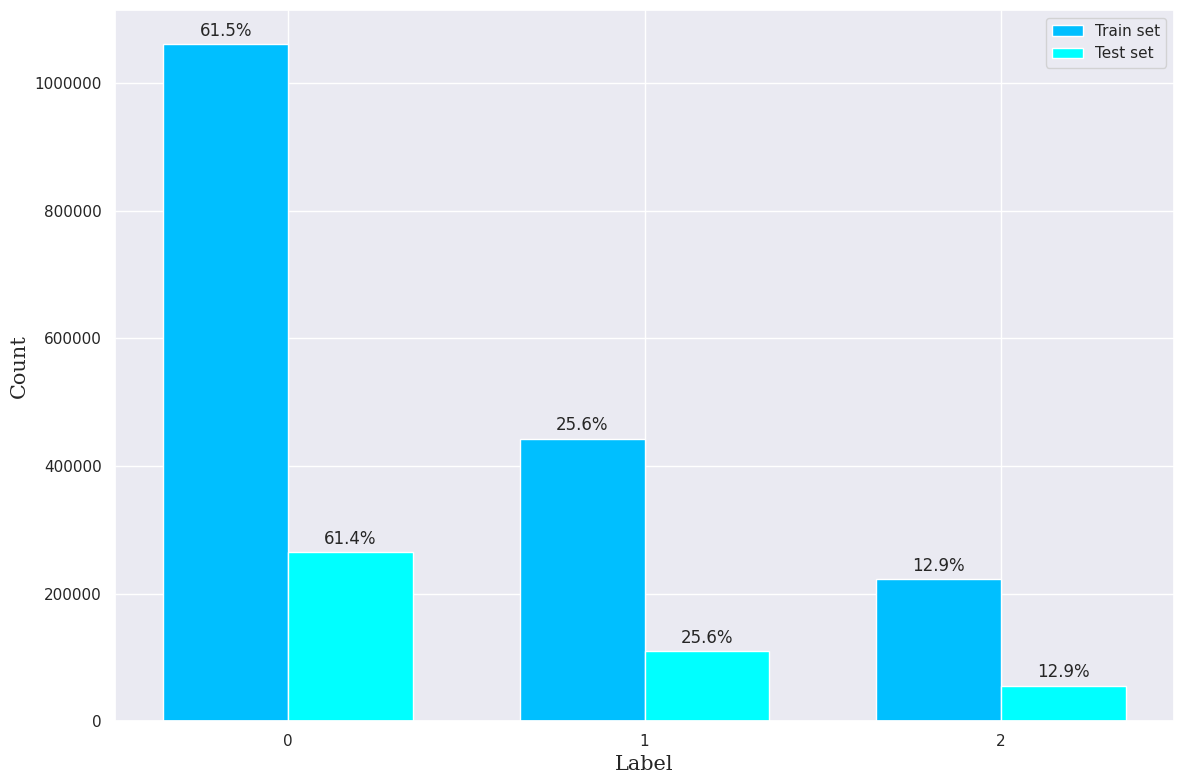

In [ ]:
df_train = train.select('LABEL').toPandas()
df_test = test.select('LABEL').toPandas()

label_train = list(df_train.LABEL.value_counts())
label_test = list(df_test.LABEL.value_counts())

rate_train = [round(x * 100 / sum(label_train), 1) for x in label_train]
rate_test = [round(x * 100 / sum(label_test), 1) for x in label_test]

labels = ['G1', 'G2', 'G3']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize =(12, 8))
rects1 = ax.bar(x - width/2, label_train, width, label='Train set', color ='#00BFFF')
rects2 = ax.bar(x + width/2, label_test, width, label='Test set', color ='#00FFFF')
ax = plt.gca()
ax.ticklabel_format(useOffset=False, style='plain')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel_train(rects):
    i = 0
    for rect in rects:
        height = rect.get_height()
        height_2 = str(rate_train[i]) + '%'
        i = i + 1
        ax.annotate('{}'.format(height_2),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
def autolabel_test(rects):
    i = 0
    for rect in rects:
        height = rect.get_height()
        height_2 = str(rate_test[i]) + '%'
        i = i + 1
        ax.annotate('{}'.format(height_2),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel_train(rects1)
autolabel_test(rects2)
# Adding Xticks
plt.xlabel('Label', fontsize = 15, fontfamily='serif')
plt.ylabel('Count', fontsize = 15, fontfamily='serif')

fig.tight_layout()
plt.show()

## Build and evaluate models

### Logistic regression

#### Training model

In [ ]:
stringIndexer = StringIndexer(inputCols=['OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST'],
                              outputCols=['OP_UNIQUE_CARRIERIndex', 'ORIGINIndex', 'DESTIndex'])

In [ ]:
oneHotEncoder = OneHotEncoder(inputCols=['OP_UNIQUE_CARRIERIndex', 'ORIGINIndex', 'DESTIndex'],
                              outputCols=['OP_UNIQUE_CARRIERVec', 'ORIGINVec','DESTVec'])

In [ ]:
assembler = VectorAssembler(inputCols=['QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_UNIQUE_CARRIERVec', 'ORIGINVec',
                                       'DESTVec', 'DISTANCE', 'CRS_DEP_TIME'], outputCol='features')

In [ ]:
# scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")

In [ ]:
LR = LogisticRegression(featuresCol='features',
                        # featuresCol = 'scaledFeatures'
                        labelCol='LABEL')

In [ ]:
pipeline = Pipeline(stages=[stringIndexer,
                            oneHotEncoder,
                            assembler,
                            # scaler,
                            LR])

In [ ]:
%%time
model_LR = pipeline.fit(train)

CPU times: user 99.6 ms, sys: 11.9 ms, total: 111 ms
Wall time: 4min 15s


#### Evaluate model

##### Train

In [ ]:
Trained = model_LR.transform(train)
Trained.show(truncate=False)
Trained.count()

+------------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+----------------------+-----------+---------+--------------------+-----------------+-----------------+-----------------------------------------------------------------------------+-------------------------------------------------------------+--------------------------------------------------------------+----------+
|ID                      |QUARTER|MONTH|DAY_OF_MONTH|DAY_OF_WEEK|OP_UNIQUE_CARRIER|ORIGIN|DEST|DISTANCE|CRS_DEP_TIME|LABEL|OP_UNIQUE_CARRIERIndex|ORIGINIndex|DESTIndex|OP_UNIQUE_CARRIERVec|ORIGINVec        |DESTVec          |features                                                                     |rawPrediction                                                |probability                                                   |prediction|
+------------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+---

1726419

In [ ]:
Trained.select('prediction').groupBy('prediction').count().show()

+----------+-------+
|prediction|  count|
+----------+-------+
|       0.0|1526198|
|       1.0| 187525|
|       2.0|  12696|
+----------+-------+



In [ ]:
predicted_train = Trained.select("prediction", 'LABEL')
predicted_train_score = predicted_train.toPandas()

print(classification_report(predicted_train_score.LABEL,
                            predicted_train_score.prediction,
                            target_names=['0', '1', '2'], digits=4))

              precision    recall  f1-score   support

           0     0.6578    0.9460    0.7760   1061322
           1     0.4505    0.1908    0.2681    442816
           2     0.3975    0.0227    0.0430    222281

    accuracy                         0.6334   1726419
   macro avg     0.5020    0.3865    0.3623   1726419
weighted avg     0.5711    0.6334    0.5514   1726419



In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol='LABEL', metricName='accuracy')
accuracy_train = evaluator.evaluate(Trained)
f1_mic = f1_score(predicted_train_score['LABEL'],
                  predicted_train_score['prediction'],
                  average = 'micro')
f1_mac = f1_score(predicted_train_score['LABEL'],
                  predicted_train_score['prediction'],
                  average = 'macro')

print('='*15+'Training Data'+'='*15)
print(f'Accuracy: {accuracy_train*100:.5f}%')
print(f'F1-Micro: {f1_mic*100:.5f}%')
print(f'F1-Macro: {f1_mac*100:.5f}%')

===============Training Data===============
Accuracy: 63.34076%
F1-Micro: 63.34076%
F1-Macro: 36.23491%


##### Test

In [ ]:
Tested = model_LR.transform(test)
Tested.show()
Tested.count()

+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+----------------------+-----------+---------+--------------------+-----------------+-----------------+--------------------+--------------------+--------------------+----------+
|                  ID|QUARTER|MONTH|DAY_OF_MONTH|DAY_OF_WEEK|OP_UNIQUE_CARRIER|ORIGIN|DEST|DISTANCE|CRS_DEP_TIME|LABEL|OP_UNIQUE_CARRIERIndex|ORIGINIndex|DESTIndex|OP_UNIQUE_CARRIERVec|        ORIGINVec|          DESTVec|            features|       rawPrediction|         probability|prediction|
+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+----------------------+-----------+---------+--------------------+-----------------+-----------------+--------------------+--------------------+--------------------+----------+
|6/1/2021_9E_ABE_A...|      2|    6|           1|          2|               9E|   ABE| ATL|   692.0|         655

431318

In [ ]:
Tested.select('prediction').groupBy('prediction').count().show()

+----------+------+
|prediction| count|
+----------+------+
|       0.0|380683|
|       1.0| 47500|
|       2.0|  3135|
+----------+------+



In [ ]:
predicted_test = Tested.select("prediction", 'LABEL')
predicted_test_score = predicted_test.toPandas()

from sklearn.metrics import classification_report
print(classification_report(predicted_test_score.LABEL,
                            predicted_test_score.prediction,
                            target_names=['0', '1', '2'], digits=4))

              precision    recall  f1-score   support

           0     0.6580    0.9452    0.7759    265007
           1     0.4503    0.1935    0.2707    110525
           2     0.3872    0.0218    0.0412     55786

    accuracy                         0.6332    431318
   macro avg     0.4985    0.3868    0.3626    431318
weighted avg     0.5698    0.6332    0.5514    431318



In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol='LABEL', metricName='accuracy')
accuracy_test = evaluator.evaluate(Tested)
f1_mic = f1_score(predicted_test_score['LABEL'],
                  predicted_test_score['prediction'],
                  average = 'micro')
f1_mac = f1_score(predicted_test_score['LABEL'],
                  predicted_test_score['prediction'],
                  average = 'macro')

print('='*15+'Testing Data'+'='*15)
print(f'Accuracy: {accuracy_test*100:.5f}%')
print(f'F1-Micro: {f1_mic*100:.5f}%')
print(f'F1-Macro: {f1_mac*100:.5f}%')

===============Testing Data===============
Accuracy: 63.31593%
F1-Micro: 63.31593%
F1-Macro: 36.26047%


#### Save & load model

In [ ]:
model_LR.write().overwrite().save(PATH+'Model/LR')

In [ ]:
model_LR_load = PipelineModel.load(PATH+'Model/LR')

### Decision tree

#### Training model

In [ ]:
stringIndexer = StringIndexer(inputCols=['OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST'],
                              outputCols=['OP_UNIQUE_CARRIERIndex', 'ORIGINIndex', 'DESTIndex'])

In [ ]:
oneHotEncoder = OneHotEncoder(inputCols=['OP_UNIQUE_CARRIERIndex', 'ORIGINIndex', 'DESTIndex'],
                              outputCols=['OP_UNIQUE_CARRIERVec', 'ORIGINVec','DESTVec'])

In [ ]:
assembler = VectorAssembler(inputCols=['QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_UNIQUE_CARRIERVec', 'ORIGINVec',
                                       'DESTVec', 'DISTANCE', 'CRS_DEP_TIME'], outputCol='features')

In [ ]:
# scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")

In [ ]:
DT = DecisionTreeClassifier(maxDepth=16, featuresCol='features', labelCol='LABEL')

In [ ]:
pipeline = Pipeline(stages=[stringIndexer,
                            oneHotEncoder,
                            assembler, DT])

In [ ]:
%%time
model_DT = pipeline.fit(train)

CPU times: user 458 ms, sys: 111 ms, total: 569 ms
Wall time: 42min 32s


#### Evaluate model

##### Train

In [ ]:
Trained = model_DT.transform(train)
Trained.show()
Trained.count()

+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+----------------------+-----------+---------+--------------------+-----------------+-----------------+--------------------+-------------------+--------------------+----------+
|                  ID|QUARTER|MONTH|DAY_OF_MONTH|DAY_OF_WEEK|OP_UNIQUE_CARRIER|ORIGIN|DEST|DISTANCE|CRS_DEP_TIME|LABEL|OP_UNIQUE_CARRIERIndex|ORIGINIndex|DESTIndex|OP_UNIQUE_CARRIERVec|        ORIGINVec|          DESTVec|            features|      rawPrediction|         probability|prediction|
+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+----------------------+-----------+---------+--------------------+-----------------+-----------------+--------------------+-------------------+--------------------+----------+
|6/1/2021_9E_ABE_A...|      2|    6|           1|          2|               9E|   ABE| ATL|   692.0|        1141|  

1726419

In [ ]:
Trained.select('prediction').groupBy('prediction').count().show()

+----------+-------+
|prediction|  count|
+----------+-------+
|       0.0|1441968|
|       1.0| 200237|
|       2.0|  84214|
+----------+-------+



In [ ]:
predicted_train = Trained.select("prediction", 'LABEL')
predicted_train_score = predicted_train.toPandas()

print(classification_report(predicted_train_score.LABEL,
                            predicted_train_score.prediction,
                            target_names=['0', '1', '2'], digits=4))

              precision    recall  f1-score   support

           0     0.6927    0.9412    0.7981   1061322
           1     0.5597    0.2531    0.3486    442816
           2     0.5920    0.2243    0.3253    222281

    accuracy                         0.6724   1726419
   macro avg     0.6148    0.4729    0.4906   1726419
weighted avg     0.6456    0.6724    0.6219   1726419



In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol='LABEL', metricName='accuracy')
accuracy_train = evaluator.evaluate(Trained)
f1_mic = f1_score(predicted_train_score['LABEL'],
                  predicted_train_score['prediction'],
                  average = 'micro')
f1_mac = f1_score(predicted_train_score['LABEL'],
                  predicted_train_score['prediction'],
                  average = 'macro')

print('='*15+'Training Data'+'='*15)
print(f'Accuracy: {accuracy_train*100:.5f}%')
print(f'F1-Micro: {f1_mic*100:.5f}%')
print(f'F1-Macro: {f1_mac*100:.5f}%')

===============Training Data===============
Accuracy: 67.23872%
F1-Micro: 67.23872%
F1-Macro: 49.06475%


##### Test

In [ ]:
Tested = model_DT.transform(test)
Tested.show()
Tested.count()

+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+----------------------+-----------+---------+--------------------+-----------------+-----------------+--------------------+-------------------+--------------------+----------+
|                  ID|QUARTER|MONTH|DAY_OF_MONTH|DAY_OF_WEEK|OP_UNIQUE_CARRIER|ORIGIN|DEST|DISTANCE|CRS_DEP_TIME|LABEL|OP_UNIQUE_CARRIERIndex|ORIGINIndex|DESTIndex|OP_UNIQUE_CARRIERVec|        ORIGINVec|          DESTVec|            features|      rawPrediction|         probability|prediction|
+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+----------------------+-----------+---------+--------------------+-----------------+-----------------+--------------------+-------------------+--------------------+----------+
|6/1/2021_9E_ABE_A...|      2|    6|           1|          2|               9E|   ABE| ATL|   692.0|         655|  

431318

In [ ]:
Tested.select('prediction').groupBy('prediction').count().show()

+----------+------+
|prediction| count|
+----------+------+
|       0.0|360182|
|       1.0| 49931|
|       2.0| 21205|
+----------+------+



In [ ]:
predicted_test = Tested.select("prediction", 'LABEL')
predicted_test_score = predicted_test.toPandas()

from sklearn.metrics import classification_report
print(classification_report(predicted_test_score.LABEL,
                            predicted_test_score.prediction,
                            target_names=['0', '1', '2'], digits=4))

              precision    recall  f1-score   support

           0     0.6820    0.9269    0.7858    265007
           1     0.4770    0.2155    0.2969    110525
           2     0.4979    0.1892    0.2742     55786

    accuracy                         0.6492    431318
   macro avg     0.5523    0.4439    0.4523    431318
weighted avg     0.6056    0.6492    0.5943    431318



In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol='LABEL', metricName='accuracy')
accuracy_test = evaluator.evaluate(Tested)
f1_mic = f1_score(predicted_test_score['LABEL'],
                  predicted_test_score['prediction'],
                  average='micro')
f1_mac = f1_score(predicted_test_score['LABEL'],
                  predicted_test_score['prediction'],
                  average='macro')

print('='*15+'Testing Data'+'='*15)
print(f'Accuracy: {accuracy_test*100:.5f}%')
print(f'F1-Micro: {f1_mic*100:.5f}%')
print(f'F1-Macro: {f1_mac*100:.5f}%')

===============Testing Data===============
Accuracy: 64.91823%
F1-Micro: 64.91823%
F1-Macro: 45.22980%


#### Save & load model

In [ ]:
model_DT.write().overwrite().save(PATH+'Model/DT')

In [9]:
import os

os.environ["PYSPARK_PYTHON"] = r"C:\Users\Lenovo\miniconda3\envs\pyspark_3.10\python.exe"
os.environ["PYSPARK_DRIVER_PYTHON"] = r"C:\Users\Lenovo\miniconda3\envs\pyspark_3.10\python.exe"

model_DT_load = PipelineModel.load('D:\PyCharm\HUST\BigData\MainProject\BigData-20251\MLModels\Model\DT')

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.runJob.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 2.0 failed 1 times, most recent failure: Lost task 0.0 in stage 2.0 (TID 2) (DESKTOP-APBCUTL.mshome.net executor driver): java.io.IOException: Cannot run program "python3": CreateProcess error=2, The system cannot find the file specified
	at java.base/java.lang.ProcessBuilder.start(ProcessBuilder.java:1143)
	at java.base/java.lang.ProcessBuilder.start(ProcessBuilder.java:1073)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:181)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:67)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:840)
Caused by: java.io.IOException: CreateProcess error=2, The system cannot find the file specified
	at java.base/java.lang.ProcessImpl.create(Native Method)
	at java.base/java.lang.ProcessImpl.<init>(ProcessImpl.java:505)
	at java.base/java.lang.ProcessImpl.start(ProcessImpl.java:158)
	at java.base/java.lang.ProcessBuilder.start(ProcessBuilder.java:1110)
	... 19 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:989)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2398)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2419)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2438)
	at org.apache.spark.api.python.PythonRDD$.runJob(PythonRDD.scala:181)
	at org.apache.spark.api.python.PythonRDD.runJob(PythonRDD.scala)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:77)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:840)
Caused by: java.io.IOException: Cannot run program "python3": CreateProcess error=2, The system cannot find the file specified
	at java.base/java.lang.ProcessBuilder.start(ProcessBuilder.java:1143)
	at java.base/java.lang.ProcessBuilder.start(ProcessBuilder.java:1073)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:181)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:67)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	... 1 more
Caused by: java.io.IOException: CreateProcess error=2, The system cannot find the file specified
	at java.base/java.lang.ProcessImpl.create(Native Method)
	at java.base/java.lang.ProcessImpl.<init>(ProcessImpl.java:505)
	at java.base/java.lang.ProcessImpl.start(ProcessImpl.java:158)
	at java.base/java.lang.ProcessBuilder.start(ProcessBuilder.java:1110)
	... 19 more


### Random forest

#### Training model

In [ ]:
stringIndexer = StringIndexer(inputCols=['OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST'],
                              outputCols=['OP_UNIQUE_CARRIERIndex', 'ORIGINIndex', 'DESTIndex'])

In [ ]:
oneHotEncoder = OneHotEncoder(inputCols=['OP_UNIQUE_CARRIERIndex', 'ORIGINIndex', 'DESTIndex'],
                              outputCols=['OP_UNIQUE_CARRIERVec', 'ORIGINVec','DESTVec'])

In [ ]:
assembler = VectorAssembler(inputCols=['QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_UNIQUE_CARRIERVec', 'ORIGINVec',
                                       'DESTVec', 'DISTANCE', 'CRS_DEP_TIME'], outputCol='features')

In [ ]:
# scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")

In [ ]:
RF = RandomForestClassifier(maxDepth=10, numTrees = 3, featuresCol='features', labelCol='LABEL')#

In [ ]:
pipeline = Pipeline(stages=[stringIndexer,
                            oneHotEncoder,
                            assembler, RF])

In [ ]:
%%time
model_RF = pipeline.fit(train)

CPU times: user 94 ms, sys: 29.7 ms, total: 124 ms
Wall time: 8min 2s


#### Evaluate model

##### Train

In [ ]:
Trained = model_RF.transform(train)
Trained.show()
Trained.count()

+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+----------------------+-----------+---------+--------------------+-----------------+-----------------+--------------------+--------------------+--------------------+----------+
|                  ID|QUARTER|MONTH|DAY_OF_MONTH|DAY_OF_WEEK|OP_UNIQUE_CARRIER|ORIGIN|DEST|DISTANCE|CRS_DEP_TIME|LABEL|OP_UNIQUE_CARRIERIndex|ORIGINIndex|DESTIndex|OP_UNIQUE_CARRIERVec|        ORIGINVec|          DESTVec|            features|       rawPrediction|         probability|prediction|
+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+----------------------+-----------+---------+--------------------+-----------------+-----------------+--------------------+--------------------+--------------------+----------+
|6/1/2021_9E_ABE_A...|      2|    6|           1|          2|               9E|   ABE| ATL|   692.0|        1141

1726419

In [ ]:
Trained.select('prediction').groupBy('prediction').count().show()

+----------+-------+
|prediction|  count|
+----------+-------+
|       0.0|1706893|
|       1.0|  19518|
|       2.0|      8|
+----------+-------+



In [ ]:
predicted_train = Trained.select("prediction", 'LABEL')
predicted_train_score = predicted_train.toPandas()

print(classification_report(predicted_train_score.LABEL,
                            predicted_train_score.prediction,
                            target_names=['0', '1', '2'], digits=4))

              precision    recall  f1-score   support

           0     0.6193    0.9960    0.7637   1061322
           1     0.4755    0.0210    0.0401    442816
           2     0.5000    0.0000    0.0000    222281

    accuracy                         0.6177   1726419
   macro avg     0.5316    0.3390    0.2680   1726419
weighted avg     0.5670    0.6177    0.4798   1726419



In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol='LABEL', metricName='accuracy')
accuracy_train = evaluator.evaluate(Trained)
f1_mic = f1_score(predicted_train_score['LABEL'],
                  predicted_train_score['prediction'],
                  average = 'micro')
f1_mac = f1_score(predicted_train_score['LABEL'],
                  predicted_train_score['prediction'],
                  average = 'macro')

print('='*15+'Training Data'+'='*15)
print(f'Accuracy: {accuracy_train*100:.5f}%')
print(f'F1-Micro: {f1_mic*100:.5f}%')
print(f'F1-Macro: {f1_mac*100:.5f}%')

===============Training Data===============
Accuracy: 61.76594%
F1-Micro: 61.76594%
F1-Macro: 26.79642%


##### Test

In [ ]:
Tested = model_RF.transform(test)
Tested.show()
Tested.count()

+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+----------------------+-----------+---------+--------------------+-----------------+-----------------+--------------------+--------------------+--------------------+----------+
|                  ID|QUARTER|MONTH|DAY_OF_MONTH|DAY_OF_WEEK|OP_UNIQUE_CARRIER|ORIGIN|DEST|DISTANCE|CRS_DEP_TIME|LABEL|OP_UNIQUE_CARRIERIndex|ORIGINIndex|DESTIndex|OP_UNIQUE_CARRIERVec|        ORIGINVec|          DESTVec|            features|       rawPrediction|         probability|prediction|
+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+----------------------+-----------+---------+--------------------+-----------------+-----------------+--------------------+--------------------+--------------------+----------+
|6/1/2021_9E_ABE_A...|      2|    6|           1|          2|               9E|   ABE| ATL|   692.0|         655

431318

In [ ]:
Tested.select('prediction').groupBy('prediction').count().show()

+----------+------+
|prediction| count|
+----------+------+
|       0.0|426419|
|       1.0|  4898|
|       2.0|     1|
+----------+------+



In [ ]:
predicted_test = Tested.select("prediction", 'LABEL')
predicted_test_score = predicted_test.toPandas()

from sklearn.metrics import classification_report
print(classification_report(predicted_test_score.LABEL,
                            predicted_test_score.prediction,
                            target_names=['0', '1', '2'], digits=4))

              precision    recall  f1-score   support

           0     0.6190    0.9960    0.7635    265007
           1     0.4822    0.0214    0.0409    110525
           2     0.0000    0.0000    0.0000     55786

    accuracy                         0.6174    431318
   macro avg     0.3671    0.3391    0.2681    431318
weighted avg     0.5039    0.6174    0.4796    431318



In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol='LABEL', metricName='accuracy')
accuracy_test = evaluator.evaluate(Tested)
f1_mic = f1_score(predicted_test_score['LABEL'],
                  predicted_test_score['prediction'],
                  average = 'micro')
f1_mac = f1_score(predicted_test_score['LABEL'],
                  predicted_test_score['prediction'],
                  average = 'macro')

print('='*15+'Testing Data'+'='*15)
print(f'Accuracy: {accuracy_test*100:.5f}%')
print(f'F1-Micro: {f1_mic*100:.5f}%')
print(f'F1-Macro: {f1_mac*100:.5f}%')

===============Testing Data===============
Accuracy: 61.74053%
F1-Micro: 61.74053%
F1-Macro: 26.81273%


#### Save & load model

In [ ]:
model_RF.write().overwrite().save(PATH+'Model/RF')

In [ ]:
model_RF_load = PipelineModel.load(PATH+'Model/RF')

### Naive Bayes

#### Training model

In [ ]:
stringIndexer = StringIndexer(inputCols=['OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST'],
                              outputCols=['OP_UNIQUE_CARRIERIndex', 'ORIGINIndex', 'DESTIndex'])

In [ ]:
oneHotEncoder = OneHotEncoder(inputCols=['OP_UNIQUE_CARRIERIndex', 'ORIGINIndex', 'DESTIndex'],
                              outputCols=['OP_UNIQUE_CARRIERVec', 'ORIGINVec','DESTVec'])

In [ ]:
assembler = VectorAssembler(inputCols=['QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_UNIQUE_CARRIERVec', 'ORIGINVec',
                                       'DESTVec', 'DISTANCE', 'CRS_DEP_TIME'], outputCol='features')

In [ ]:
# scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")

In [ ]:
NB = NaiveBayes(featuresCol='features', labelCol='LABEL', smoothing=0.0003, modelType="multinomial")

In [ ]:
pipeline = Pipeline(stages=[stringIndexer,
                            oneHotEncoder,
                            assembler, NB])

In [ ]:
%%time
model_NB = pipeline.fit(train)

CPU times: user 36.5 ms, sys: 9.18 ms, total: 45.7 ms
Wall time: 59.2 s


#### Evaluate model

##### Train

In [ ]:
Trained = model_NB.transform(train)
Trained.show()
Trained.count()

+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+----------------------+-----------+---------+--------------------+-----------------+-----------------+--------------------+--------------------+--------------------+----------+
|                  ID|QUARTER|MONTH|DAY_OF_MONTH|DAY_OF_WEEK|OP_UNIQUE_CARRIER|ORIGIN|DEST|DISTANCE|CRS_DEP_TIME|LABEL|OP_UNIQUE_CARRIERIndex|ORIGINIndex|DESTIndex|OP_UNIQUE_CARRIERVec|        ORIGINVec|          DESTVec|            features|       rawPrediction|         probability|prediction|
+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+----------------------+-----------+---------+--------------------+-----------------+-----------------+--------------------+--------------------+--------------------+----------+
|6/1/2021_9E_ABE_A...|      2|    6|           1|          2|               9E|   ABE| ATL|   692.0|        1141

1726419

In [ ]:
Trained.select('prediction').groupBy('prediction').count().show()

+----------+------+
|prediction| count|
+----------+------+
|       0.0|154134|
|       1.0|664173|
|       2.0|908112|
+----------+------+



In [ ]:
predicted_train = Trained.select("prediction", 'LABEL')
predicted_train_score = predicted_train.toPandas()

print(classification_report(predicted_train_score.LABEL,
                            predicted_train_score.prediction,
                            target_names=['0', '1', '2'], digits=4))

              precision    recall  f1-score   support

           0     0.7089    0.1030    0.1798   1061322
           1     0.2791    0.4187    0.3350    442816
           2     0.1432    0.5850    0.2301    222281

    accuracy                         0.2460   1726419
   macro avg     0.3771    0.3689    0.2483   1726419
weighted avg     0.5259    0.2460    0.2261   1726419



In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol='LABEL', metricName='accuracy')
accuracy_train = evaluator.evaluate(Trained)
f1_mic = f1_score(predicted_train_score['LABEL'],
                  predicted_train_score['prediction'],
                  average = 'micro')
f1_mac = f1_score(predicted_train_score['LABEL'],
                  predicted_train_score['prediction'],
                  average = 'macro')

print('='*15+'Training Data'+'='*15)
print(f'Accuracy: {accuracy_train*100:.5f}%')
print(f'F1-Micro: {f1_mic*100:.5f}%')
print(f'F1-Macro: {f1_mac*100:.5f}%')

===============Training Data===============
Accuracy: 24.60104%
F1-Micro: 24.60104%
F1-Macro: 24.82850%


##### Test

In [ ]:
Tested = model_NB.transform(test)
Tested.show()
Tested.count()

+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+----------------------+-----------+---------+--------------------+-----------------+-----------------+--------------------+--------------------+--------------------+----------+
|                  ID|QUARTER|MONTH|DAY_OF_MONTH|DAY_OF_WEEK|OP_UNIQUE_CARRIER|ORIGIN|DEST|DISTANCE|CRS_DEP_TIME|LABEL|OP_UNIQUE_CARRIERIndex|ORIGINIndex|DESTIndex|OP_UNIQUE_CARRIERVec|        ORIGINVec|          DESTVec|            features|       rawPrediction|         probability|prediction|
+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+----------------------+-----------+---------+--------------------+-----------------+-----------------+--------------------+--------------------+--------------------+----------+
|6/1/2021_9E_ABE_A...|      2|    6|           1|          2|               9E|   ABE| ATL|   692.0|         655

431318

In [ ]:
Tested.select('prediction').groupBy('prediction').count().show()

+----------+------+
|prediction| count|
+----------+------+
|       0.0| 38436|
|       1.0|166053|
|       2.0|226829|
+----------+------+



In [ ]:
predicted_test = Tested.select("prediction", 'LABEL')
predicted_test_score = predicted_test.toPandas()

from sklearn.metrics import classification_report
print(classification_report(predicted_test_score.LABEL,
                            predicted_test_score.prediction,
                            target_names=['0', '1', '2'], digits=4))

              precision    recall  f1-score   support

           0     0.7133    0.1035    0.1807    265007
           1     0.2783    0.4181    0.3341    110525
           2     0.1439    0.5853    0.2311     55786

    accuracy                         0.2464    431318
   macro avg     0.3785    0.3689    0.2486    431318
weighted avg     0.5282    0.2464    0.2265    431318



In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol='LABEL', metricName='accuracy')
accuracy_test = evaluator.evaluate(Tested)
f1_mic = f1_score(predicted_test_score['LABEL'],
                  predicted_test_score['prediction'],
                  average = 'micro')
f1_mac = f1_score(predicted_test_score['LABEL'],
                  predicted_test_score['prediction'],
                  average = 'macro')

print('='*15+'Testing Data'+'='*15)
print(f'Accuracy: {accuracy_test*100:.5f}%')
print(f'F1-Micro: {f1_mic*100:.5f}%')
print(f'F1-Macro: {f1_mac*100:.5f}%')

===============Testing Data===============
Accuracy: 24.64006%
F1-Micro: 24.64006%
F1-Macro: 24.86390%


#### Save & load model

In [ ]:
model_NB.write().overwrite().save(PATH+'Model/NB')

In [ ]:
model_NB_load = PipelineModel.load(PATH+'Model/NB')

### XGBoost

#### Training model

In [12]:
stringIndexer = StringIndexer(inputCols=['OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST'],
                              outputCols=['OP_UNIQUE_CARRIERIndex', 'ORIGINIndex', 'DESTIndex'])

In [13]:
oneHotEncoder = OneHotEncoder(inputCols=['OP_UNIQUE_CARRIERIndex', 'ORIGINIndex', 'DESTIndex'],
                              outputCols=['OP_UNIQUE_CARRIERVec', 'ORIGINVec','DESTVec'])

In [14]:
assembler = VectorAssembler(inputCols=['QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_UNIQUE_CARRIERVec', 'ORIGINVec',
                                       'DESTVec', 'DISTANCE', 'CRS_DEP_TIME'], outputCol='features')

In [25]:
XGB = SparkXGBClassifier(features_col='features', label_col='LABEL')

In [28]:
pipeline = Pipeline(stages=[stringIndexer,
                                    oneHotEncoder,
                                    assembler,
                                    XGB])

In [29]:
%%time
model_XGB = pipeline.fit(train)

INFO:XGBoost-PySpark:Running xgboost-3.1.1 on 1 workers with
	booster params: {'objective': 'multi:softprob', 'device': 'cpu', 'num_class': 3, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Finished xgboost training!


CPU times: user 434 ms, sys: 81.3 ms, total: 515 ms
Wall time: 14min 45s


#### Evaluate model

##### Train

In [30]:
Trained_xgb = model_XGB.transform(train)
Trained_xgb.show()
Trained_xgb.count()

+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+----------------------+-----------+---------+--------------------+-----------------+-----------------+--------------------+--------------------+----------+--------------------+
|                  ID|QUARTER|MONTH|DAY_OF_MONTH|DAY_OF_WEEK|OP_UNIQUE_CARRIER|ORIGIN|DEST|DISTANCE|CRS_DEP_TIME|LABEL|OP_UNIQUE_CARRIERIndex|ORIGINIndex|DESTIndex|OP_UNIQUE_CARRIERVec|        ORIGINVec|          DESTVec|            features|       rawPrediction|prediction|         probability|
+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+----------------------+-----------+---------+--------------------+-----------------+-----------------+--------------------+--------------------+----------+--------------------+
|6/1/2021_9E_ABE_A...|      2|    6|           1|          2|               9E|   ABE| ATL|   692.0|        1141

1726419

In [31]:
Trained_xgb.select('prediction').groupBy('prediction').count().show()

+----------+-------+
|prediction|  count|
+----------+-------+
|       0.0|1468400|
|       1.0| 198940|
|       2.0|  59079|
+----------+-------+



In [36]:
predicted_train_xgb = Trained_xgb.select("prediction", 'LABEL')
predicted_train_score_xgb = predicted_train_xgb.toPandas()

print(classification_report(predicted_train_score_xgb.LABEL,
                            predicted_train_score_xgb.prediction,
                            target_names=['0', '1', '2'], digits=4))

              precision    recall  f1-score   support

           0     0.6808    0.9419    0.7903   1061322
           1     0.5024    0.2257    0.3115    442816
           2     0.5658    0.1504    0.2376    222281

    accuracy                         0.6563   1726419
   macro avg     0.5830    0.4393    0.4465   1726419
weighted avg     0.6202    0.6563    0.5964   1726419



In [39]:
evaluator = MulticlassClassificationEvaluator(labelCol='LABEL', metricName='accuracy')
accuracy_train = evaluator.evaluate(Trained_xgb)
f1_mic = f1_score(predicted_train_score_xgb['LABEL'],
                  predicted_train_score_xgb['prediction'],
                  average = 'micro')
f1_mac = f1_score(predicted_train_score_xgb['LABEL'],
                  predicted_train_score_xgb['prediction'],
                  average = 'macro')

print('='*15+'Training Data'+'='*15)
print(f'Accuracy: {accuracy_train*100:.5f}%')
print(f'F1-Micro: {f1_mic*100:.5f}%')
print(f'F1-Macro: {f1_mac*100:.5f}%')

===============Training Data===============
Accuracy: 65.62990%
F1-Micro: 65.62990%
F1-Macro: 44.64781%


##### Test

In [40]:
Tested_xgb = model_XGB.transform(test)
Tested_xgb.show()
Tested_xgb.count()

+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+----------------------+-----------+---------+--------------------+-----------------+-----------------+--------------------+--------------------+----------+--------------------+
|                  ID|QUARTER|MONTH|DAY_OF_MONTH|DAY_OF_WEEK|OP_UNIQUE_CARRIER|ORIGIN|DEST|DISTANCE|CRS_DEP_TIME|LABEL|OP_UNIQUE_CARRIERIndex|ORIGINIndex|DESTIndex|OP_UNIQUE_CARRIERVec|        ORIGINVec|          DESTVec|            features|       rawPrediction|prediction|         probability|
+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+----------------------+-----------+---------+--------------------+-----------------+-----------------+--------------------+--------------------+----------+--------------------+
|6/1/2021_9E_ABE_A...|      2|    6|           1|          2|               9E|   ABE| ATL|   692.0|         655

431318

In [34]:
Tested_xgb.select('prediction').groupBy('prediction').count().show()

+----------+------+
|prediction| count|
+----------+------+
|       0.0|366691|
|       1.0| 49899|
|       2.0| 14728|
+----------+------+



In [41]:
predicted_test_xgb = Tested_xgb.select("prediction", 'LABEL')
predicted_test_score_xgb = predicted_test_xgb.toPandas()

from sklearn.metrics import classification_report
print(classification_report(predicted_test_score_xgb.LABEL,
                            predicted_test_score_xgb.prediction,
                            target_names=['0', '1', '2'], digits=4))

              precision    recall  f1-score   support

           0     0.6798    0.9406    0.7892    265007
           1     0.4950    0.2235    0.3079    110525
           2     0.5557    0.1467    0.2322     55786

    accuracy                         0.6541    431318
   macro avg     0.5768    0.4369    0.4431    431318
weighted avg     0.6164    0.6541    0.5938    431318



In [42]:
evaluator = MulticlassClassificationEvaluator(labelCol='LABEL', metricName='accuracy')
accuracy_test = evaluator.evaluate(Tested_xgb)
f1_mic = f1_score(predicted_test_score_xgb['LABEL'],
                  predicted_test_score_xgb['prediction'],
                  average = 'micro')
f1_mac = f1_score(predicted_test_score_xgb['LABEL'],
                  predicted_test_score_xgb['prediction'],
                  average = 'macro')

print('='*15+'Testing Data'+'='*15)
print(f'Accuracy: {accuracy_test*100:.5f}%')
print(f'F1-Micro: {f1_mic*100:.5f}%')
print(f'F1-Macro: {f1_mac*100:.5f}%')

===============Testing Data===============
Accuracy: 65.41392%
F1-Micro: 65.41392%
F1-Macro: 44.30776%


#### Save & load model

In [43]:
model_XGBoost.write().overwrite().save(PATH+'Model/XGB')

In [44]:
model_XGBoost_load = PipelineModel.load(PATH+'Model/XGB')